In [1]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_columns = None

# Project overview
Energy is used daily for phones, computers, washing machines, heaters and a vast array of appliances.
Our dependence on electricity makes it critical to accurately predict how much energy we will need to generate on any given day.
Hence, our project aims to correlate and model temperature's effect on energy demand.
We will begin by importing and cleaning our two datasets, before analysing the data integrity and creating visualisations to intuitively highlight the impact several variables have on Australia's net energy usage.
These visualisations aim to show not only energy and temperature but yearly trends, seasonal shifts and other potential anomalies.
After this we create a basic timeseries model, to evaluate precisely how well we're able to measure energy demand on a day-to-day basis.
This report will conclude with a summary of our results (including the significance of different independent and extraneous variables) and a series of suggestions on how our work can be improved going forwards.

To help achieve these results we will use a range of technical and statistical tools.
We heavily rely on Python and its associated libraries (largely Pandas for data cleaning and management, Numpy for numerical calculations, MatPlotLib for graphs and Scikit learn for machine learning modelling).

# Supplied data
Our weather data is collected from the Bureau of Meteorology's (BOM) Automatic Weather Stations and energy data from The Australian Energy Market Operator (AEMO).
The data comes in the form of a series of CSVs containing measurements every 30 minutes.
The weather data contains precipitation (mm), temperature (°C), relative humidity (%), wind speed (km/h), wind direction (° true), maximum wind gust speed (km/h), pressure (hPa) and whether manual/automatic measurements were taken.
It is quite common for there to be multiple features (columns) with nearly identical data (i.e. different forms of temperature or pressure).
Energy data provides total demand and an RRP (energy price).

The energy and temperature data both come in the form of raw CSV files.
There are over 1000 energy CSV's, and one temperature CSV per state.
There is also an additional temperature CSV with a small amount of extra information, and a notes file (describing the dataset, its columns and a few potential pitfalls).

A large portion of this data will be processed to eliminate any present trends, biases or inconsistencies. Yet, not all the provided data from BOM and AEMO are relevant (so many columns are removed).

# Data Cleaning
## Import the data
When importing data, we first need to find a list of all the data files/their paths.
We can then merge the separate spreadsheets into two dataframes (one for temperature and one for energy).
The process of finding the file paths, loading the separate CSV files and then finally concatenating them together can be tedious, however, this ultimately allows for easy access to our data.

In [2]:
energy_locations = os.listdir("../Data/Energy")
temperature_locations = os.listdir("../Data/Temperature")

energy_CSVs = [pd.read_csv("../Data/Energy/" + location) for location in energy_locations]
temperature_CSVs = [pd.read_csv("../Data/Temperature/" + location) for location in temperature_locations if "Data" in location]

/home/kamron/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (12,14,18,20,22,24,26,28,32) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/kamron/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (12,14,18,20,22,32) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/kamron/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (12,14,18,20,28,32) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/kamron/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (12,16,22,24,26,28,30) have mixed types.Specify dtype option on import or set low_memory=False.
  i

In [3]:
energy_data = pd.concat(energy_CSVs, ignore_index=True)
temperature_data = pd.concat(temperature_CSVs, ignore_index=True)

# Note some excess data is shaved off here for simplicity
stations_data = pd.read_csv("../Data/Temperature/HM01X_StnDet_999999999743964.txt", skiprows=5, header=None, usecols=range(1, 21), names=["StationNumber", "RainfulDistrict", "Station", "StationOpenDate", "StationCloseDate", "Latitude", "Longitude", "LocationMethod", "State", "StationHeight", "BarometerHeight", "WMO", "FirstYear", "LastYear", "CompletionPercent", "YQualityPercent", "NQualityPercent", "WQualityPercent", "SQualityPercent", "IQualityPercent"])

## Column standardising
To ensure it is easy to find specific data features, all column names are standardised.
We have chosen to use PascalCase here.

As there are two sets of dates available here, we append a 1 to the end of the columns.

In [4]:
energy_data.columns
temperature_data.columns
stations_data.columns

Index(['REGION', 'SETTLEMENTDATE', 'TOTALDEMAND', 'RRP', 'PERIODTYPE'], dtype='object')

Index(['hm', 'Station Number', 'Year Month Day Hour Minutes in YYYY', 'MM',
       'DD', 'HH24', 'MI format in Local time',
       'Year Month Day Hour Minutes in YYYY.1', 'MM.1', 'DD.1', 'HH24.1',
       'MI format in Local standard time',
       'Precipitation since 9am local time in mm',
       'Quality of precipitation since 9am local time',
       'Air Temperature in degrees C', 'Quality of air temperature',
       'Wet bulb temperature in degrees C', 'Quality of Wet bulb temperature',
       'Dew point temperature in degrees C',
       'Quality of dew point temperature', 'Relative humidity in percentage %',
       'Quality of relative humidity', 'Wind speed in km/h',
       'Wind speed quality', 'Wind direction in degrees true',
       'Wind direction quality',
       'Speed of maximum windgust in last 10 minutes in  km/h',
       'Quality of speed of maximum windgust in last 10 minutes',
       'Mean sea level pressure in hPa', 'Quality of mean sea level pressure',
       'Stati

Index(['StationNumber', 'RainfulDistrict', 'Station', 'StationOpenDate',
       'StationCloseDate', 'Latitude', 'Longitude', 'LocationMethod', 'State',
       'StationHeight', 'BarometerHeight', 'WMO', 'FirstYear', 'LastYear',
       'CompletionPercent', 'YQualityPercent', 'NQualityPercent',
       'WQualityPercent', 'SQualityPercent', 'IQualityPercent'],
      dtype='object')

In [5]:
energy_data.columns = ["Region", "Date", "TotalDemand", "RRP", "PeriodType"]
temperature_data.columns = [
    "HM", "StationNumber", "Year1", "Month1", "Day1", "Hour1", "Minute1", "Year", "Month", "Day", "Hour", "Minute", "Precipitation", "PrecipitationQuality",
    "AirTemperature", "AirTemperatureQuality", "WetBulbTemperature", "WetBulbTemperatureQuality", "DewTemperature", "DewTemperatureQuality", "RelativeHumidity",
    "RelativeHumidityQuality", "WindSpeed", "WindSpeedQuality", "WindDirection", "WindDirectionQuality", "WindgustSpeed", "WindgustSpeedQuality", "SeaPressure",
    "SeaPressureQuality", "StationPressure", "StationPressureQuality", "AWSFlag", "#"
]

## Remove any easily found unnecessary data
Our dataset contains a multitude of columns, and several have no information within them.
As these feature columns often contain a variety of null types (sometimes Numpy's NaN, sometimes an empty string and sometimes a 0 for a non-integer or category column), we analyse the number of unique elements.

Reducing the number of columns present additionally makes it easy to quickly look at the state of the data when moving forward.

In [6]:
def remove_non_uniques(dataframe: pd.DataFrame, filter = []):
    remove = [name for name, series in dataframe.items() if len(series.unique()) <= 2 and not name in filter]
    dataframe.drop(remove, axis=1, inplace=True)
    return remove

print("Removed:")
remove_non_uniques(energy_data)
remove_non_uniques(temperature_data)
remove_non_uniques(stations_data, "LocationMethod")

# Manually remove extra columns
stations_data.drop("StationOpenDate", axis=1, inplace=True)

Removed:


['PeriodType']

['HM',
 'PrecipitationQuality',
 'AirTemperatureQuality',
 'WetBulbTemperatureQuality',
 'DewTemperatureQuality',
 'RelativeHumidityQuality',
 'WindSpeedQuality',
 'WindDirectionQuality',
 'WindgustSpeedQuality',
 'SeaPressureQuality',
 'StationPressureQuality',
 '#']

['StationCloseDate',
 'FirstYear',
 'LastYear',
 'YQualityPercent',
 'NQualityPercent',
 'WQualityPercent',
 'SQualityPercent',
 'IQualityPercent']

In [7]:
energy_data.columns
temperature_data.columns
stations_data.columns

Index(['Region', 'Date', 'TotalDemand', 'RRP'], dtype='object')

Index(['StationNumber', 'Year1', 'Month1', 'Day1', 'Hour1', 'Minute1', 'Year',
       'Month', 'Day', 'Hour', 'Minute', 'Precipitation', 'AirTemperature',
       'WetBulbTemperature', 'DewTemperature', 'RelativeHumidity', 'WindSpeed',
       'WindDirection', 'WindgustSpeed', 'SeaPressure', 'StationPressure',
       'AWSFlag'],
      dtype='object')

Index(['StationNumber', 'RainfulDistrict', 'Station', 'Latitude', 'Longitude',
       'LocationMethod', 'State', 'StationHeight', 'BarometerHeight', 'WMO',
       'CompletionPercent'],
      dtype='object')

## Deal with multiple dates
The provided data contains two sets of date values.
The provided notes state that first dates are local and the second are local standard.
Whilst generally identical, local time incorporates daylight saving (shifting the clock back/forward by an hour).
For simplicity, local standard time is used.

In [8]:
# Remove extra dates
temperature_data.drop(["Year1", "Month1", "Day1", "Hour1", "Minute1"], axis=1, inplace=True)

# Reformat dates into Pandas' datatime64 objects
# Replacing old format
temperature_data["Date"] = pd.to_datetime(temperature_data[["Year", "Month", "Day", "Hour", "Minute"]])
energy_data["Date"] = pd.to_datetime(energy_data["Date"])

temperature_data.drop(["Year", "Month", "Day", "Hour", "Minute"], axis=1, inplace=True)

## Check for duplicated rows
On top of finding and removing useless columns, we can also drop useless rows.
This is far more straightforward as the provided Pandas functions work flawlessly with almost no manual input.

In [9]:
energy_data.drop_duplicates(inplace=True)
temperature_data.drop_duplicates(inplace=True)
stations_data.drop_duplicates(inplace=True)

## Converting datatypes
The next step is to convert the data types. 
To ensure that we can plot and model our data, we use specific Pandas/Python datatypes.
The use of specific datatypes like DateTime and Category are crucial in providing a simple but flexible API.
This will latter allow indexing through dates (so ```loc``` with multiple conditional statements aren't repeatedly used)!

Although Pandas includes functions for parsing data, these are of little use because of the special scenarios present here.
These include spaces before and after numbers and hashtags in a random location.
To easily overcome these issues a function is created which finds all columns with generic objects, and performs some operation on each entry.
This works specifically because Pandas does not set a specific datatype for strings.

For AWS Flag, we assume that null values are recorded manually, as this is the worst-case scenario.

In [10]:
def to_object_columns(lambda_function):
    string_columns = temperature_data.select_dtypes("object").columns
    temperature_data[string_columns] = temperature_data[string_columns].apply(lambda_function)

In [11]:
to_object_columns(lambda column: column.str.strip())

In [12]:
temperature_data["AWSFlag"] = temperature_data["AWSFlag"].replace("", 0).astype("category")
temperature_data["AWSFlag"].fillna(0, inplace=True)
temperature_data["RelativeHumidity"] = temperature_data["RelativeHumidity"].replace("###", np.NaN)

In [13]:
to_object_columns(lambda column: pd.to_numeric(column))

In [14]:
temperature_data.dtypes

StationNumber                  int64
Precipitation                float64
AirTemperature               float64
WetBulbTemperature           float64
DewTemperature               float64
RelativeHumidity             float64
WindSpeed                    float64
WindDirection                float64
WindgustSpeed                float64
SeaPressure                  float64
StationPressure              float64
AWSFlag                     category
Date                  datetime64[ns]
dtype: object

## Grouping data
Energy and temperature data are recorded in specific regions, however, they use different keys/criteria (so we must align them ourselves).
This is the intermediary stage before the two datasets can be joined together.

More than one weather station existed in Victoria (for a short time) and here both stations data are just added together.
*Although this may lead to a slightly biased dataset (if there ends up being slightly more data for Victoria than other states), using separate models for separate states will eliminate this issue*.

In [15]:
energy_data["Region"].unique()
temperature_data["StationNumber"].unique()

array(['VIC1', 'SA1', 'TAS1', 'QLD1', 'NSW1'], dtype=object)

array([94029, 86071, 66062, 40913, 86338, 23090])

In [16]:
region_remove_number_map = {"SA1": "SA", "QLD1": "QLD", "NSW1": "NSW", "VIC1": "VIC", "TAS1": "TAS"}
station_to_region_map = {23090: "SA", 40913: "QLD", 66062: "NSW", 86071: "VIC", 94029: "TAS", 86338: "VIC"}

temperature_data["Region"] = temperature_data["StationNumber"].map(station_to_region_map)
energy_data["Region"] = energy_data["Region"].map(region_remove_number_map)

temperature_data.drop("StationNumber", axis=1, inplace=True)

In [17]:
energy_data.set_index("Date", inplace=True)
temperature_data.set_index("Date", inplace=True)

## Graphing missing data
Here we need to graph out the different variables to visualise the existence of null or missing data as there is a relatively large amount of null data.
Here we are looking for large or frequent gaps, as data in these sections can't just be filled in.

The data for `WindSpeed`, `WindgustSpeed` and `WindDirection` tends to have large gaps, implying that these columns should be removed.
Likewise with `DewTemperature`, `RelativeHumididty`, `Precipitation` and `AirTemperature`.

This also suggests that there has been significant instrumentation failure or ineffective practices to document weather data constantly across Australia.

In the opposite situation where there are the occasional missing values, it should be safe to interpolate their values.
*Note that this is because the missing values don't occur on a regular basis, as this would mean that the frequency of measurements for different datasets would instead first require downsampling.*

There are cases where there is minimal to no missing data which occurs with `TotalDemand` and `WetbulbTemperature` (and so these are likely better features to model with).

### Energy Demand
Here is an example where there is no visually missing data for each of the states. This makes the data here easy for analysis as there are no concerns that need to be accounted for.

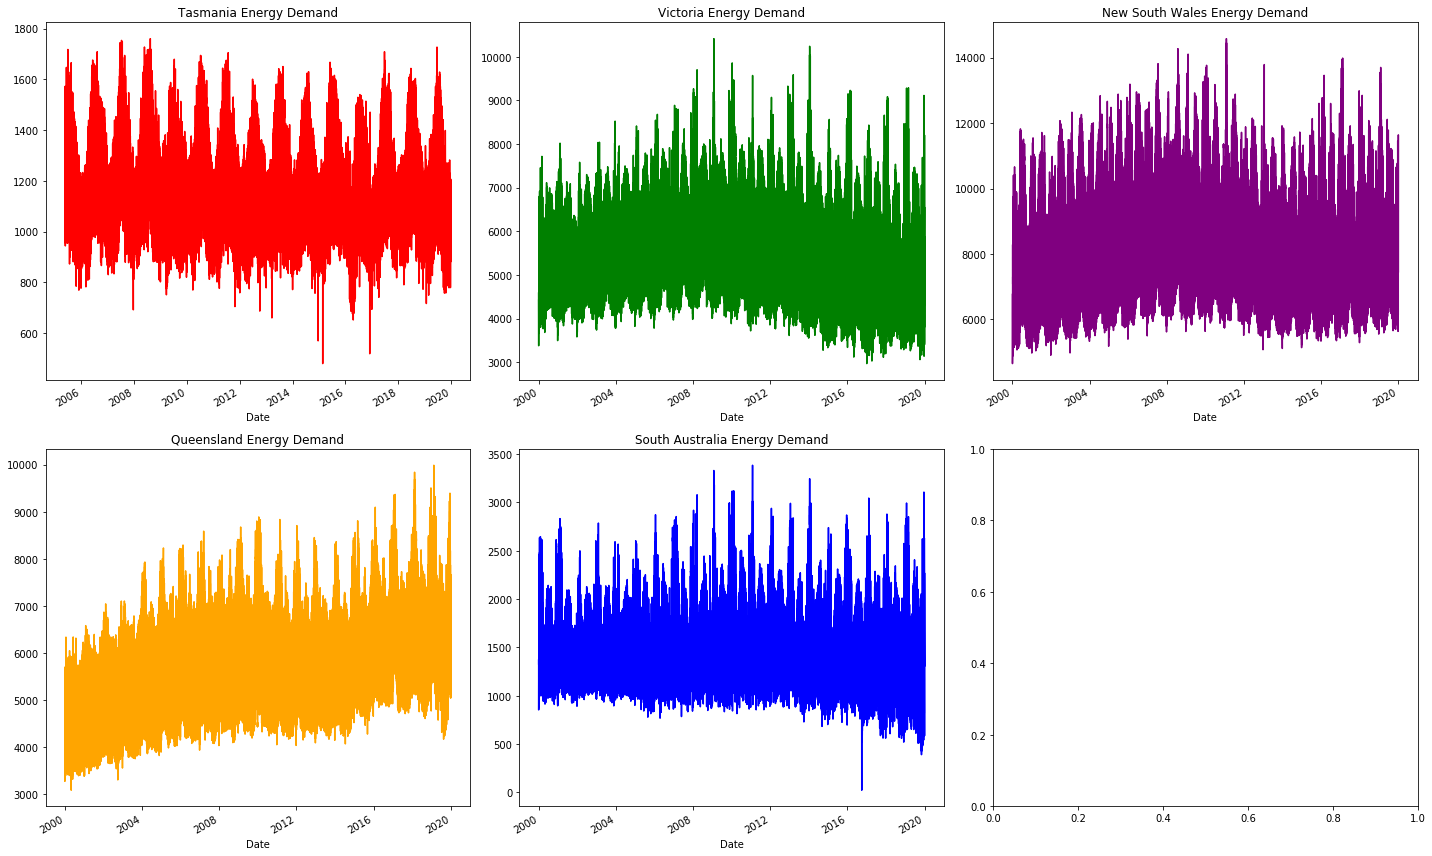

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12), tight_layout=True)

energy_data.groupby("Region").get_group("TAS")["TotalDemand"]["2000":"2019"].plot(color= "red",title="Tasmania Energy Demand",ax=axes[0,0])
energy_data.groupby("Region").get_group("VIC")["TotalDemand"]["2000":"2019"].plot(color= "green",title="Victoria Energy Demand",ax=axes[0,1])
energy_data.groupby("Region").get_group("NSW")["TotalDemand"]["2000":"2019"].plot(color= "purple",title="New South Wales Energy Demand",ax=axes[0,2])
energy_data.groupby("Region").get_group("QLD")["TotalDemand"]["2000":"2019"].plot(color= "orange",title="Queensland Energy Demand",ax=axes[1,0])
energy_data.groupby("Region").get_group("SA")["TotalDemand"]["2000":"2019"].plot(color="blue",title="South Australia Energy Demand",ax=axes[1,1])

### Wet Bulb Temperature
Data is present for the full 20 year period for all states except for about 9 months of Victoria and before 2006 in Tasmania.
This is not of significant concern as there plenty of data for the rest of Victoria and all the other states.

To show the relation between different temperature measures (`WetBulbTemperature` and `AirTemperature`), we proceed also graph one against the other.
The lack of missing `WetBulbTemperature` in the first set of plots, along with the near linear relationship shown in the second graph accentuates how wet bulb temperature is a viable alternative to air temperature.
*Note that this can also be seen in a correlation table, however the graph is a slightly more intuitive way to show it.*

The one potential flaw here is the increasing deviation with temperature.

*Note that we specifically graph data in Victoria between 2000 and 2011 to avoid the presence of missing data within `AirTemperature`*.

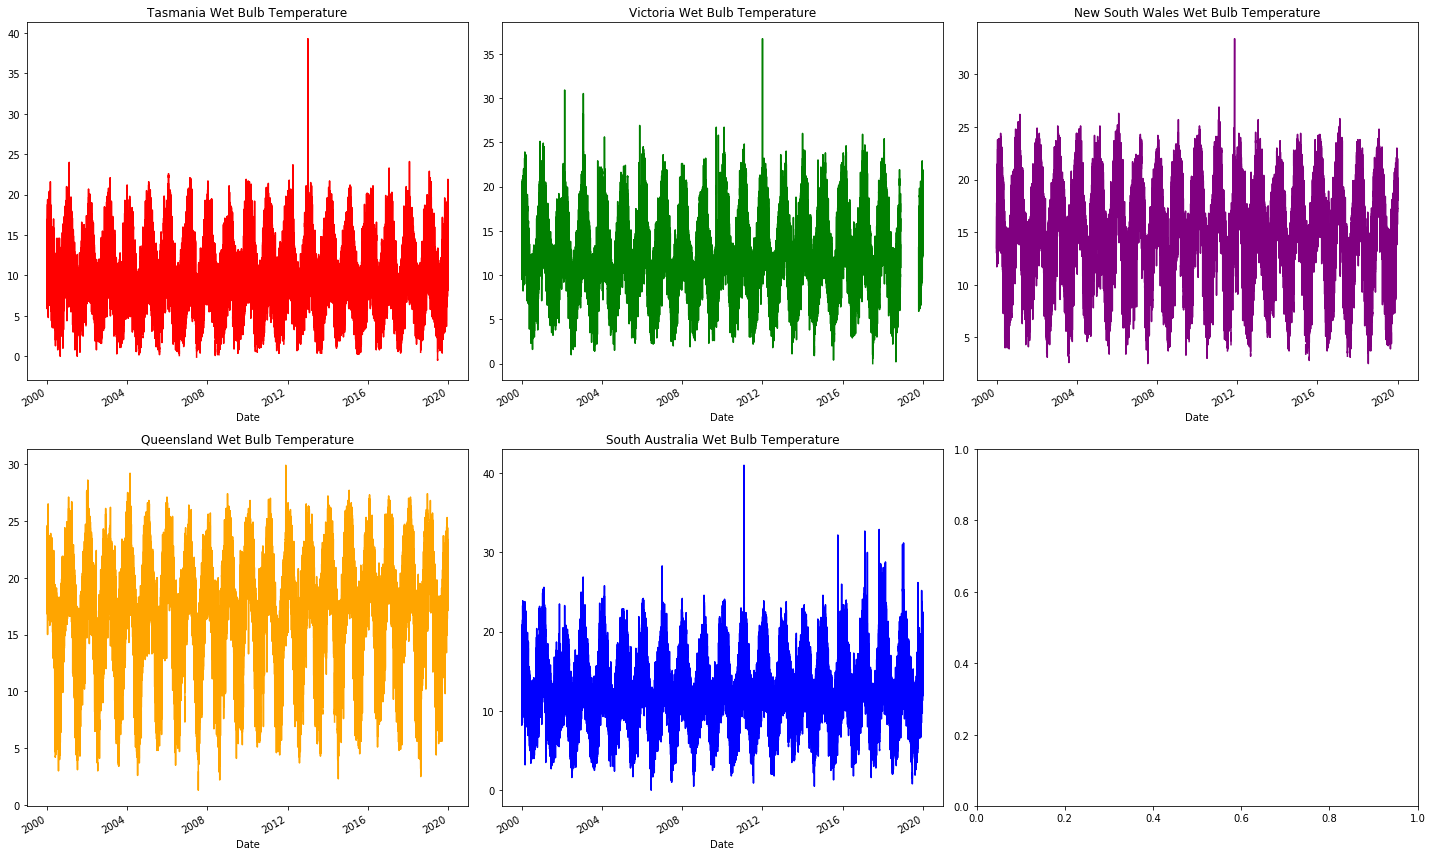

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12), tight_layout=True)

temperature_data.groupby("Region").get_group("TAS")["WetBulbTemperature"]["2000":"2019"].plot(color= "red",title="Tasmania Wet Bulb Temperature",ax=axes[0,0])
temperature_data.groupby("Region").get_group("VIC")["WetBulbTemperature"]["2000":"2019"].plot(color= "green",title="Victoria Wet Bulb Temperature",ax=axes[0,1])
temperature_data.groupby("Region").get_group("NSW")["WetBulbTemperature"]["2000":"2019"].plot(color= "purple",title="New South Wales Wet Bulb Temperature",ax=axes[0,2])
temperature_data.groupby("Region").get_group("QLD")["WetBulbTemperature"]["2000":"2019"].plot(color= "orange",title="Queensland Wet Bulb Temperature",ax=axes[1,0])
temperature_data.groupby("Region").get_group("SA")["WetBulbTemperature"]["2000":"2019"].plot(color= "blue",title="South Australia Wet Bulb Temperature",ax=axes[1,1])

Text(0.5, 0, 'Air Temperature (°C)')

Text(0, 0.5, 'Wet Bulb Temperature (°C)')

Text(0.5, 1.0, 'Victoria Air and Wet Bulb Temperature: 2000-2011')

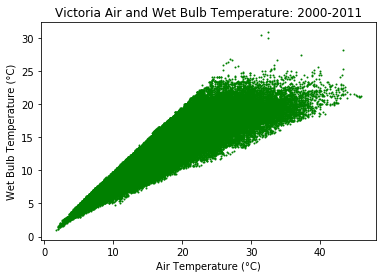

In [20]:
ax = temperature_data.groupby("Region").get_group("VIC")["2000":"2011"].plot(kind="scatter",x="AirTemperature", y="WetBulbTemperature", s=1, color= "green")
ax.set_xlabel('Air Temperature (°C)')
ax.set_ylabel("Wet Bulb Temperature (°C)")
ax.set_title('Victoria Air and Wet Bulb Temperature: 2000-2011')

### Low-data features
In the following graphs, there is a significant amount of missing air temperature data over large periods ranging from a few months to 8 years.
This makes the data insufficient for our purposes.
This is especially visible for New South Wales (since it is worst effected).
Massive blank gaps are visible wherever there is missing data.

The situation is equally bad for numerous features (similar patterns where most states have years worth of missing data and one state has almost none):
* Precipitation
* AirTemperature
* DewTemperature
* RelativeHumidity
* WindSpeed
* WindDirection
* WindgustSpeed

*Note that we only show air temperature for brevity, but the same code may be rerun for these columns too.*

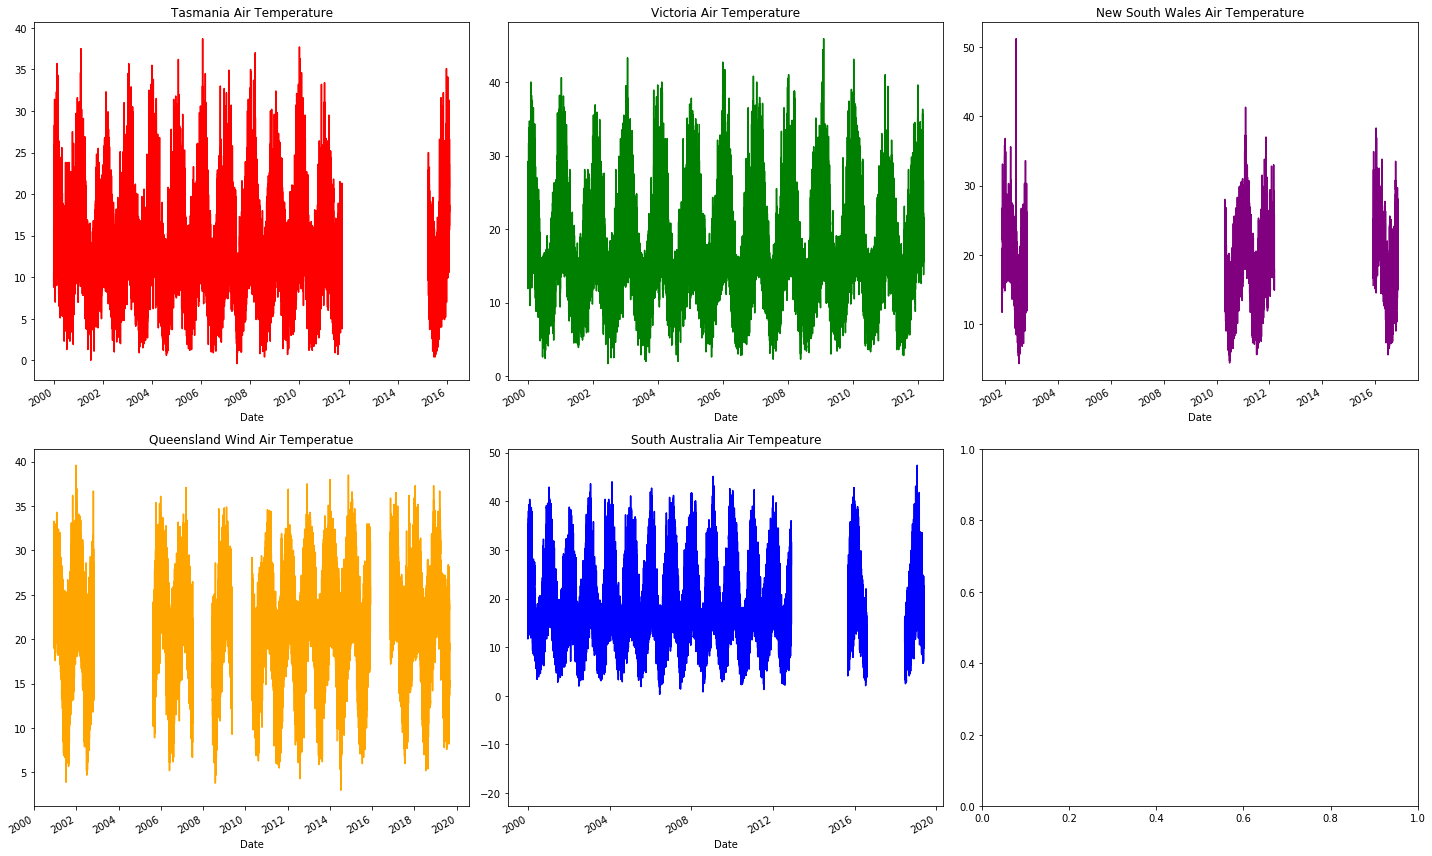

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12), tight_layout=True)

temperature_data.groupby("Region").get_group("TAS")["AirTemperature"]["2000":"2019"].plot(color= "red",title="Tasmania Air Temperature",ax=axes[0,0])
temperature_data.groupby("Region").get_group("VIC")["AirTemperature"]["2000":"2019"].plot(color= "green",title="Victoria Air Temperature",ax=axes[0,1])
temperature_data.groupby("Region").get_group("NSW")["AirTemperature"]["2000":"2019"].plot(color= "purple",title="New South Wales Air Temperature",ax=axes[0,2])
temperature_data.groupby("Region").get_group("QLD")["AirTemperature"]["2000":"2019"].plot(color= "orange",title="Queensland Wind Air Temperatue",ax=axes[1,0])
temperature_data.groupby("Region").get_group("SA")["AirTemperature"]["2000":"2019"].plot(color= "blue",title="South Australia Air Tempeature",ax=axes[1,1])

## Finding missing data
Through analysing where and how our data is missing above, we were able to identify which columns contained useful information to keep/interpolate and what unfortunately needed to be completely removed.
*This of course is only necessary for the temperature data, as there is no missing energy data.*

The columns with large amounts of missing data are completely removed, and columns with small amounts can have their missing values interpolated.
*It may seem unnecessary to draw the graphs when we're able to see percentage missing, but note that this doesn't give us the full picture!*
Being able to visually see the frequency of missing data on a state-to-state level is a quick and easy way to figgure out what needed to be removed.

In [22]:
def get_null_counts(dataframe: pd.DataFrame):
    return dataframe.isnull().mean()[dataframe.isnull().mean() > 0]

In [23]:
get_null_counts(energy_data)
get_null_counts(temperature_data)

Series([], dtype: float64)

Precipitation         0.229916
AirTemperature        0.444437
WetBulbTemperature    0.011324
DewTemperature        0.375311
RelativeHumidity      0.375312
WindSpeed             0.532966
WindDirection         0.432305
WindgustSpeed         0.403183
SeaPressure           0.137730
StationPressure       0.011135
dtype: float64

In [24]:
remove_columns = ["Precipitation", "AirTemperature", "DewTemperature", "RelativeHumidity", "WindSpeed", "WindDirection", "WindgustSpeed"]
temperature_data.drop(remove_columns, axis=1, inplace=True)

# Note that using inplace currently throws an error
# So interpolated columns must be manually overridden
missing_columns = list(get_null_counts(temperature_data).keys())
temperature_data[missing_columns] = temperature_data[missing_columns].interpolate(method="time")

## Combining energy and temperature data
To be able to create a model which predicts energy demand using temperature data we need to align our temperature and energy measurements together (i.e. by date).
This is accomplished by using closest value merges.
These merges work with sorted data, so we begin by sorting our data by date.
We can then use the ```merge_asof``` function (where we specify that our data is grouped ```by``` region) to merge the two datasets (where the closest entries get combined).
As our data is nearly always recorded in 30-minute intervals, we only merge two rows if their dates differ by less than 30 minutes.

Any unpaired rows result in null values, and since we have a small number of them we can tell that our merge happened successfully!

In [25]:
energy_data.sort_index(inplace=True)
temperature_data.sort_index(inplace=True)

data = pd.merge_asof(energy_data, temperature_data, left_index=True, right_index=True, by="Region", tolerance=pd.Timedelta("30 min"))

In [26]:
get_null_counts(data)
data.dropna(inplace=True)

WetBulbTemperature    0.001634
SeaPressure           0.001634
StationPressure       0.001634
AWSFlag               0.001634
dtype: float64

In [27]:
data

,Region,TotalDemand,RRP,WetBulbTemperature,SeaPressure,StationPressure,AWSFlag
Date,,,,,,,
2000-01-01 00:30:00,NSW,6763.57000,15.64,14.1,1011.1,1006.4,0
2000-01-01 00:30:00,SA,1328.68667,38.54,10.1,1018.7,1012.6,0
2000-01-01 00:30:00,QLD,3905.56833,39.40,19.2,1007.2,1006.2,0
2000-01-01 00:30:00,VIC,4419.03667,9.97,10.5,1017.0,1013.1,0
2000-01-01 01:00:00,SA,1375.14833,38.54,10.1,1018.5,1012.4,0
...,...,...,...,...,...,...,...
2020-01-01 00:00:00,QLD,6218.39000,52.15,21.6,1014.9,1013.8,0
2020-01-01 00:00:00,VIC,4372.27000,85.23,12.3,1014.9,1014.0,0
2020-01-01 00:00:00,SA,1474.11000,85.95,12.3,1014.9,1010.6,0


## Saving final data

In [28]:
pd.to_pickle(data, "../Data/Data.pickle")